In [18]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import CSwapGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from collections import Counter
from qiskit.circuit import Reset
import numpy as np
%matplotlib inline

In [19]:
def generate_theta_list(mode, n_levels, lam=2.0):
    total_pegs = (n_levels * (n_levels + 1)) // 2
    if mode == "walk":
        return [np.pi / 2] * total_pegs
    elif mode == "exp":
        thetas = []
        for level in range(n_levels):
            for _ in range(level + 1):
                p = 1 - np.exp(-lam * (level + 1))
                p = np.clip(p, 0.001, 0.9999)  
                theta = 2 * np.arccos(np.sqrt(p))
                thetas.append(theta)
        return thetas

In [20]:
def build_exponential_qgb_explicit(n_levels, theta_list):
    n_q = 2 * n_levels + 1
    anc = QuantumRegister(1, "a")
    q = QuantumRegister(n_q, "q")
    c = ClassicalRegister(n_q, "c")
    qc = QuantumCircuit(anc, q, c)

    mid = n_q // 2
    qc.x(q[mid])

    peg_idx = 0
    for level in range(n_levels):
        start = mid - level
        for peg in range(level + 1):
            i = start + 2 * peg
            qc.append(Reset(), [anc[0]])
            qc.rx(theta_list[peg_idx], anc[0])
            if i + 2 < len(q):
                qc.append(CSwapGate(), [anc[0], q[i], q[i + 1]])
                qc.cx(q[i + 1], anc[0])
                qc.append(CSwapGate(), [anc[0], q[i + 1], q[i + 2]])
                peg_idx += 1

        if level < n_levels - 1:
            for peg in range(level + 1):
                i = start + 2 * peg + 2
                j = i - 1
                qc.cx(q[i], q[j])
                qc.append(Reset(), [q[i]])

    qc.measure(q, c)
    return qc




In [21]:
def post_process_counts(counts, n_qubits, mode="exp"):
    bin_counts = {}
    for bitstring, count in counts.items():
        b = bitstring[::-1]

        if mode == "exp":
            if b.count("1") == 1:
                i = b.index("1")
                rel_pos = i - (n_qubits // 2)
                bin_counts[rel_pos] = bin_counts.get(rel_pos, 0) + count

        elif mode == "walk":
            filtered = ''.join([b[i] for i in range(0, n_qubits, 2)])
            idx = filtered.count("1")
            bin_counts[idx] = bin_counts.get(idx, 0) + count

    return dict(sorted(bin_counts.items()))

In [24]:
def run_qgb(mode="exp", n_levels=4, shots=4096, lam=0.6):
    theta_list = generate_theta_list(mode, n_levels, lam)
    qc = build_exponential_qgb_explicit(n_levels, theta_list)
    sim = AerSimulator()
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=shots).result()
    counts = result.get_counts()

    bin_counts = post_process_counts(counts, qc.num_qubits - 1, mode)

    plot_histogram(bin_counts)
    plt.title(f"{n_levels}-Level QGB ({mode.upper()} mode)")
    plt.xlabel("Position")
    plt.ylabel("Counts")
    plt.tight_layout()
    plt.show()

    return qc, counts, bin_counts




Exponential Distribution:


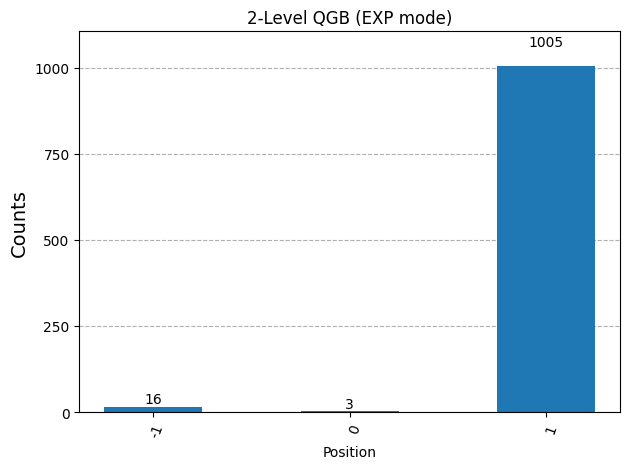

Quantum Walk Distribution:


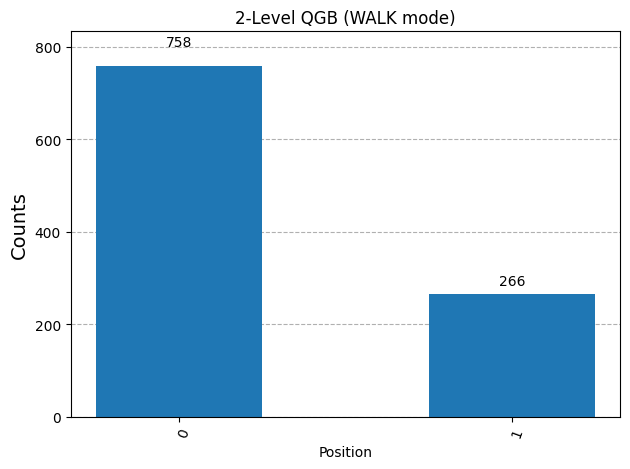

In [25]:
if __name__ == "__main__":
    print("Exponential Distribution:")
    run_qgb(mode="exp", n_levels= 2 , shots=1024, lam=2.0)

    print("Quantum Walk Distribution:")
    run_qgb(mode="walk", n_levels=2, shots=1024)